In [1]:
import os

os.environ["KERAS_BACKEND"] = "jax"

import timeit
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import ops
import keras_hub

import plotly.express as px

import gc
import tensorflow as tf
from keras import backend as K

2025-08-07 16:19:21.853372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754576361.868012  148191 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754576361.872544  148191 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754576361.884641  148191 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754576361.884655  148191 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754576361.884657  148191 computation_placer.cc:177] computation placer alr

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    box = box.reshape(-1)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def inference_resizing(image, pad=True):
    # Compute Preprocess Shape
    image = ops.cast(image, dtype="float32")
    old_h, old_w = image.shape[0], image.shape[1]
    scale = 1024 * 1.0 / max(old_h, old_w)
    new_h = old_h * scale
    new_w = old_w * scale
    preprocess_shape = int(new_h + 0.5), int(new_w + 0.5)

    # Resize the image
    image = ops.image.resize(image[None, ...], preprocess_shape)[0]

    # Pad the shorter side
    if pad:
        pixel_mean = ops.array([123.675, 116.28, 103.53])
        pixel_std = ops.array([58.395, 57.12, 57.375])
        image = (image - pixel_mean) / pixel_std
        h, w = image.shape[0], image.shape[1]
        pad_h = 1024 - h
        pad_w = 1024 - w
        image = ops.pad(image, [(0, pad_h), (0, pad_w), (0, 0)])
        # KerasHub now rescales the images and normalizes them.
        # Just unnormalize such that when KerasHub normalizes them
        # again, the padded values map to 0.
        image = image * pixel_std + pixel_mean
    return image

In [3]:
model = keras_hub.models.SAMImageSegmenter.from_preset("sam_base_sa1b") # ls -l ~/.cache/kagglehub/models/keras/sam/keras/sam_huge_sa1b/5/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9919196e-08..1.0].


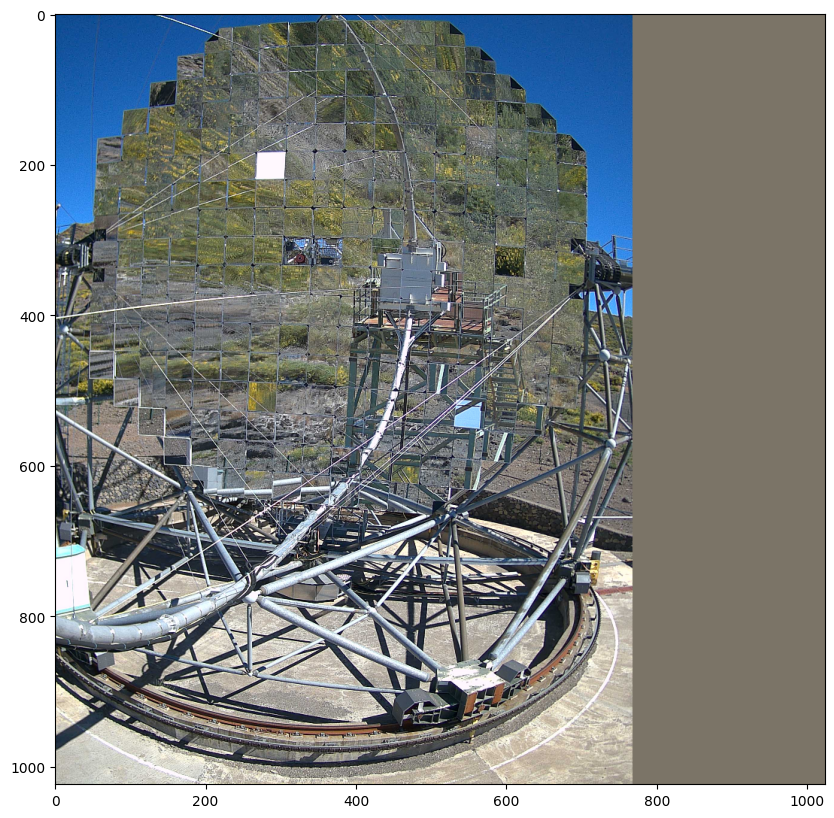

In [4]:
# Load our image
image = np.array(keras.utils.load_img("IRCamM1T20250621_161000M.jpg"))
image = inference_resizing(image)

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
plt.axis("on")
plt.show()

In [ ]:
points = [ 
    (295, 105.5)
    (275, 105.5),
    (255, 105.5)
         ]

In [9]:
def get_output_and_show_point(image, input_box):
    outputs = model.predict(
    {
        "images": image[np.newaxis, ...],
        "boxes": input_box[np.newaxis, np.newaxis, ...]
        }
    )

    # Resize the mask to our image shape i.e. (1024, 1024)
    mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
    # Convert the logits to a numpy array
    # and convert the logits to a boolean mask
    mask = ops.convert_to_numpy(mask) > 0.0
    iou_score = ops.convert_to_numpy(outputs["iou_pred"][0][0])
    
    plt.figure(figsize=(10, 10))
    plt.imshow(ops.convert_to_numpy(image) / 255.0)
    show_mask(mask, plt.gca())
    # show_points(input_point, input_label, plt.gca())
    show_box(input_box, plt.gca())
    plt.title(f"IoU Score: {iou_score:.3f}", fontsize=18)
    plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9919196e-08..1.0].


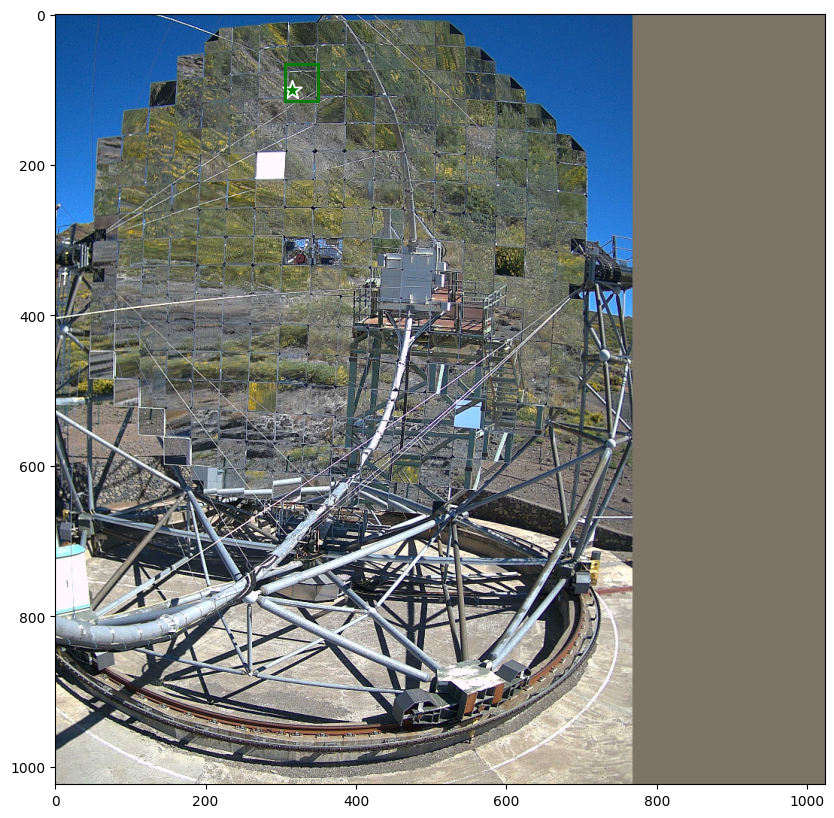

In [32]:
# Define the input point prompt
input_point = np.array([[315, 100]])
input_label = np.array([1])

input_box = np.array([[305, 65], [350, 115]])

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_points(input_point, input_label, plt.gca())
show_box(input_box, plt.gca())
plt.axis("on")
plt.show()

In [33]:
outputs = model.predict(
    {
        "images": image[np.newaxis, ...],
        "points": np.concatenate(
            [input_point[np.newaxis, ...], np.zeros((1, 1, 2))], axis=1
        ),
        "boxes": input_box[np.newaxis, np.newaxis, ...],
        "labels": np.concatenate(
            [input_label[np.newaxis, ...], np.full((1, 1), fill_value=-1)], axis=1
        ),
    }
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9919196e-08..1.0].


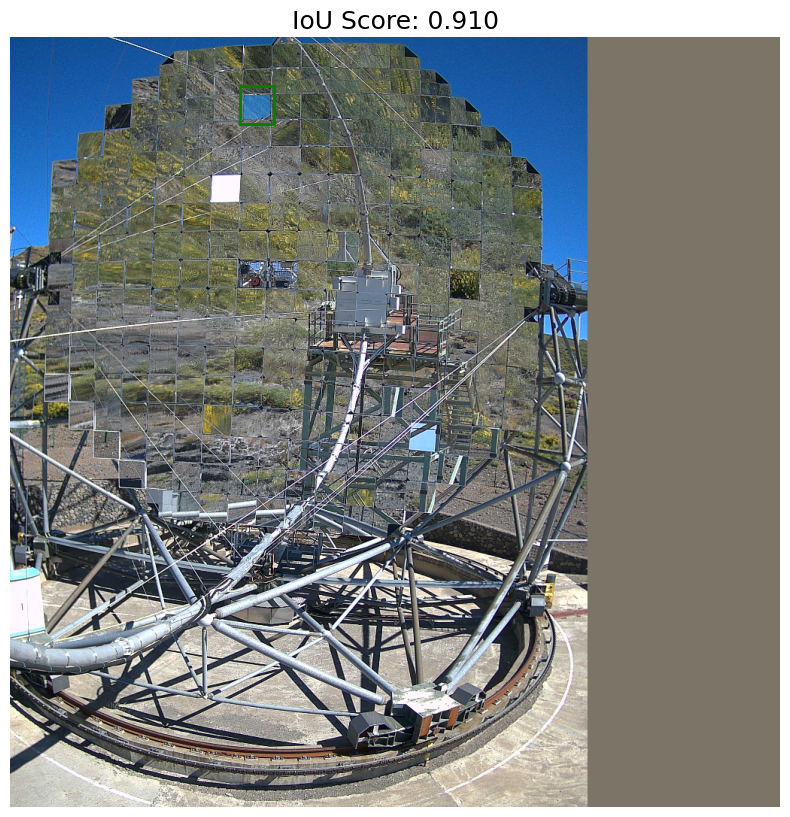

In [34]:
# Resize the mask to our image shape i.e. (1024, 1024)
mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
# Convert the logits to a numpy array
# and convert the logits to a boolean mask
mask = ops.convert_to_numpy(mask) > 0.0
iou_score = ops.convert_to_numpy(outputs["iou_pred"][0][0])

plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_mask(mask, plt.gca())
# show_points(input_point, input_label, plt.gca())
show_box(input_box, plt.gca())
plt.title(f"IoU Score: {iou_score:.3f}", fontsize=18)
plt.axis("off")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9919196e-08..1.0].


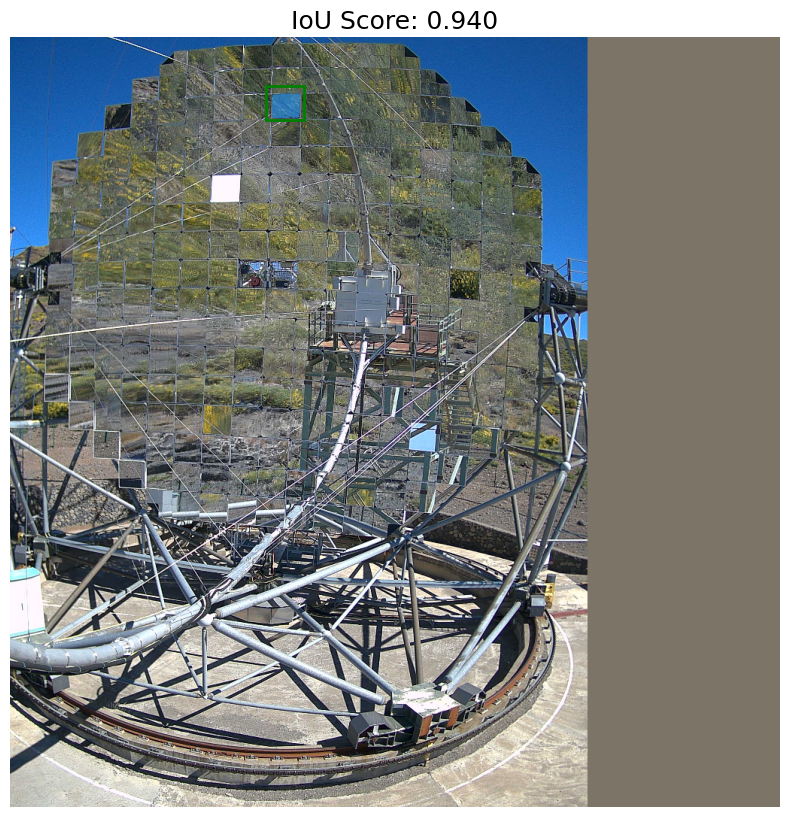

In [14]:
get_output_and_show_point(image, input_box)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9919196e-08..1.0].


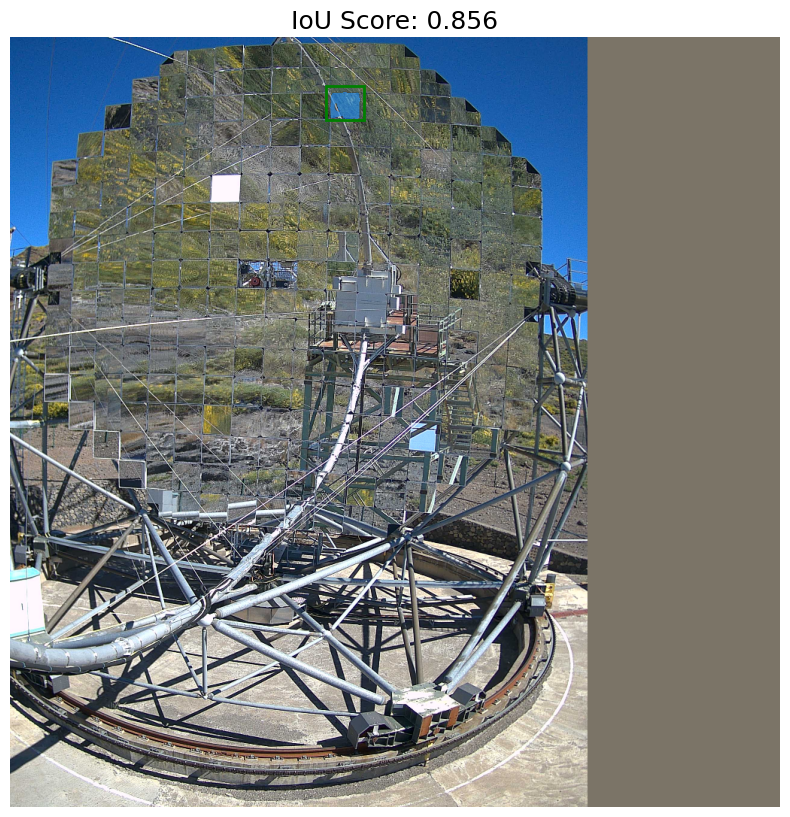

In [17]:
get_output_and_show_point(image, input_box)

In [35]:
# 1. Convert to NumPy arrays if needed
image_np = ops.convert_to_numpy(image)     # shape: (H, W, 3)
mask_np = ops.convert_to_numpy(mask)       # shape: (H, W), dtype: bool

# 2. Find bounding box around the mask
ys, xs = np.where(mask_np)  # get coordinates of True pixels

# In case there's no mask
if len(xs) == 0 or len(ys) == 0:
    raise ValueError("Mask is empty — no pixels to crop.")

# 3. Get bounding box coordinates
x_min, x_max = xs.min(), xs.max()
y_min, y_max = ys.min(), ys.max()

# 4. Crop the image and (optionally) the mask
cropped_image = image_np[y_min:y_max+1, x_min:x_max+1]
cropped_mask  = mask_np[y_min:y_max+1, x_min:x_max+1]

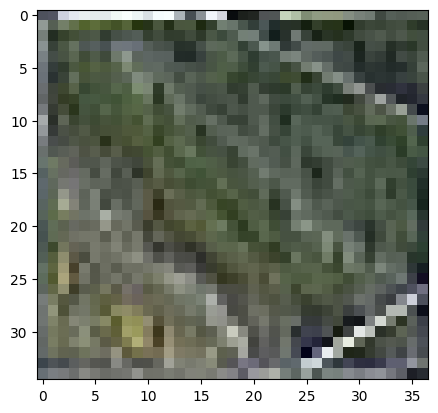

In [36]:
plt.imshow(cropped_image.astype(np.uint8))

In [31]:
cropped_image.shape

(31, 71, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9919196e-08..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9919196e-08..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9919196e-08..1.0].


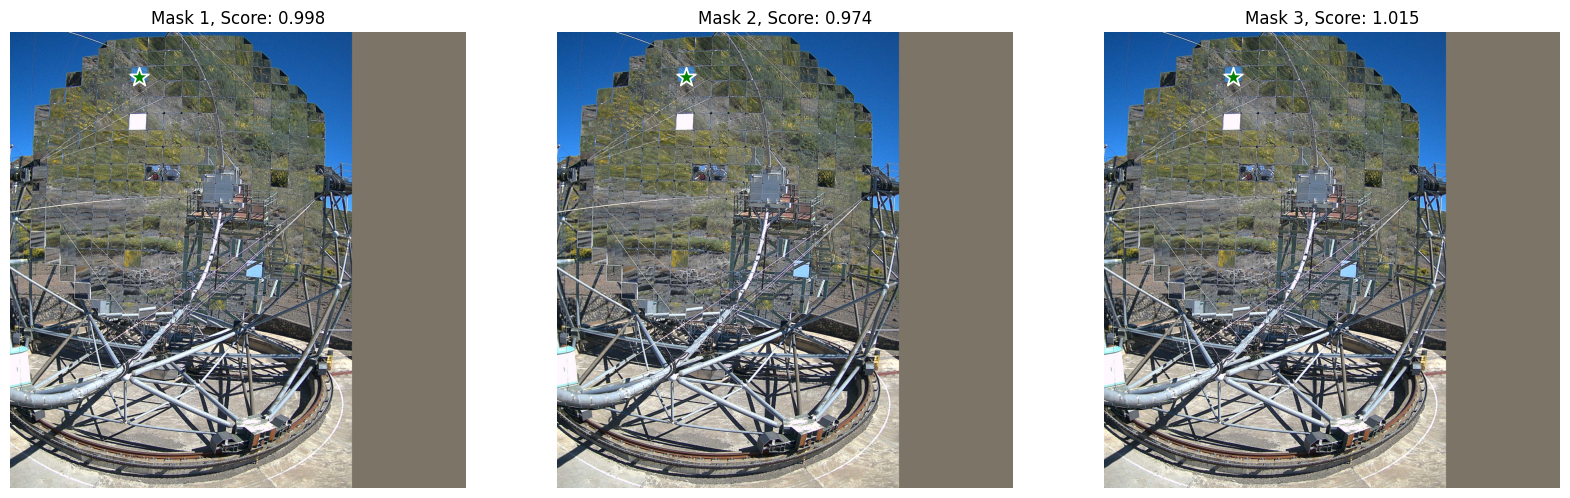

In [92]:
fig, ax = plt.subplots(1, 3, figsize=(20, 60))
masks, scores = outputs["masks"][0][1:], outputs["iou_pred"][0][1:]
for i, (mask, score) in enumerate(zip(masks, scores)):
    mask = inference_resizing(mask[..., None], pad=False)[..., 0]
    mask, score = map(ops.convert_to_numpy, (mask, score))
    mask = 1 * (mask > 0.0)
    ax[i].imshow(ops.convert_to_numpy(image) / 255.0)
    show_mask(mask, ax[i])
    show_points(input_point, input_label, ax[i])
    ax[i].set_title(f"Mask {i+1}, Score: {score:.3f}", fontsize=12)
    ax[i].axis("off")
plt.show()

In [74]:
outputs["masks"].shape

(1, 4, 256, 256)

In [76]:
outputs["masks"][0, 1, :, :]

array([[-21.955921, -35.718292, -32.84679 , ..., -54.98419 , -54.605537,
        -52.249146],
       [-20.648102, -49.305485, -29.155354, ..., -61.236355, -50.79517 ,
        -52.39644 ],
       [-23.478287, -48.660137, -33.836613, ..., -53.171143, -63.885166,
        -55.595146],
       ...,
       [-33.068275, -49.63455 , -40.33071 , ..., -40.24865 , -36.03393 ,
        -34.29224 ],
       [-37.050285, -58.220703, -53.810986, ..., -32.89946 , -40.98463 ,
        -33.19464 ],
       [-28.181202, -46.809914, -40.401566, ..., -38.593452, -36.63092 ,
        -31.845303]], dtype=float32)

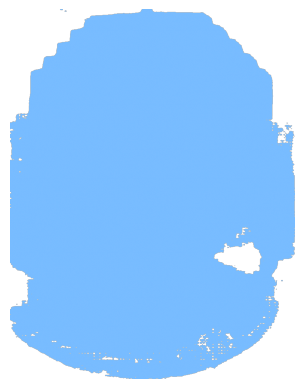

In [51]:
overlay_crop = crop_mask_overlay(mask, image)

plt.imshow(overlay_crop)
plt.axis("off")
plt.show()

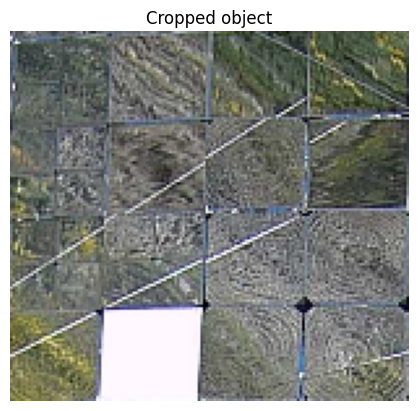

In [48]:
plt.imshow(cropped_img.astype(np.uint8))
plt.axis("off")
plt.title("Cropped object")
plt.show()

In [9]:
gc.collect()
K.clear_session()